# Surface observation postprocessing 


In these note books we try some machine learning techniques on a real world but simple problem.

We are trying to improve the ECMWF IFS forecast of temperature using postprocessing. 

Specifically we are trying to predict the different between station observations 2m-temperature and the IFS forecast prediction at the nearest gridpoint to the observation location.

We will explore several physically motivated predictors.

# Using linear regression (with nonlinear features)

Linear regression can be a powerful tool for model building. Even in cases where it does not produce the most accurate model, it is easier to interprete the decisions it has made which could help understand the more complex modelling solution.

Here we use linear regression of nonlinear features to model the problem. We still solve a least-squares problem to find the best fitting linear model, but we include powers of the predictors as inputs.
e.g. instead of building y = a + b*x we can learn y = a + b * x + c * x^2


In [ ]:
#Install the package for our dataset
!pip install climetlab-mltc-surface-observation-postprocessing --quiet

In [1]:
# An example of using machine learning to model weather forecast error 
# based on work of Fenwick Coope & Matthew Chantry as part of work 
# funded by IFAB (https://www.ifabfoundation.org/)

# A few imports of tools we will use. Where possible it is always worth using
# existing tools, even if the mathematics are simple to write down yourself.
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model
import matplotlib.pyplot as plt

from sop_utils import imgBufferFromVectors

import climetlab as cml

In [2]:
# Load a list of 36 hour forecast errors in 2m temperature.
# The forecasts come from ECMWF's high resolution forecast system.
# The measurements come from around 8000 weather stations around the world.
forecast_error = cml.load_dataset('mltc-surface-observation-postprocessing',field='forecast_error').to_numpy()

# We suspect that the errors in the forecast can be explained simply by the time of day.

# Load the local time of day corresponding to when the measurements were made.
time_of_day = cml.load_dataset('mltc-surface-observation-postprocessing',field='time_of_day').to_numpy()

# Later we will add in the soil temperature
soil_temperature = cml.load_dataset('mltc-surface-observation-postprocessing',field='soil_temperature').to_numpy()

# Note that an important step of data preprocessing has already been carried out in the curation of the dataset.
# Spurious data has already been removed from the dataset based upon a range of categories,
# e.g. stations with inconsistent measurement locations, repeated values, or even physically 
# invalid numbers (>100C).
# If you are starting on a new project this is a key step to clean the data.

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/mchantry/climetlab-mltc-sop/blob/main/LICENSE. If you do not agree with such terms, do not download the data. 


In [13]:
#Split each of the predictands and predictors in a random train/test split
# we use 80% of the data for training & 20% for testing

# Here the data has already been anonomised, so we cannot use information about
# stations or time to ensure independence of our dataset.
# With more meta-data we could follow the lessons learnt earlier today
# and ensure the data subsets are independent
(forecast_error_train, forecast_error_test, 
    time_of_day_train, time_of_day_test, 
    soil_temperature_train,  soil_temperature_test) = train_test_split(forecast_error,
                                                                       time_of_day,
                                                                       soil_temperature,
                                                                       test_size = 0.2,
                                                                       random_state = 42,
                                                                      )

In [4]:
# Find the line of best fit of a cubic polynomial using scikit-learn
# y = c0 + c1 * x + c2 * x^2 + c3 * x^3

# Create the data
X = np.concatenate([time_of_day_train, time_of_day_train**2, time_of_day_train**3],axis=-1)
# Create linear regression object
reg = linear_model.LinearRegression()

# Note: The model is linear in the fit coefficients c0, c1, c2, and c3. This is the "linear"
#       in linear regression. Using linear regression we are fitting a cubic polynomial
#       function which is non-linear in x.

# Train the model using the data
reg.fit(X, forecast_error_train)

# Rename the coefficients found by the fit
c0 = reg.intercept_
c1 = reg.coef_[0][0]
c2 = reg.coef_[0][1]
c3 = reg.coef_[0][2]

# Make a line of best fit for plotting
x = np.linspace(0, 24, 49)
y = c0 + c1 * x + c2 * x**2 + c3 * x**3

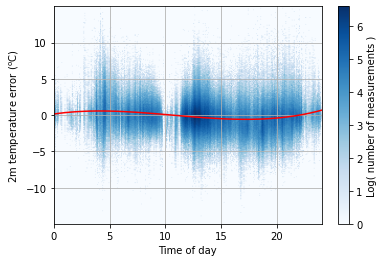

In [5]:
# Make an image of the time of day against the forecast error
tod_buffer, ax_extent, count = imgBufferFromVectors(time_of_day_test, forecast_error_test,
                                                    nx=256, ny=256, extent=[],
                                                    calc_average=False)
# Plot the number of measurements at each time of day and forecast error
plt.imshow(np.log((count==0.0)+count),
           cmap='Blues', origin='lower',
           extent=ax_extent, aspect='auto')

plt.xlim([0, 24])
plt.grid()
plt.xlabel('Time of day')
plt.ylabel('2m temperature error ($^\mathrm{o}$C)')
cb = plt.colorbar()
cb.set_label('Log( number of measurements )')

# Line of best fit
plt.plot(x,y,'red')

plt.show()

# Note: The model (red line) is better than nothing, but does not account for the variation
#       in 2m temperature error at single time of day (eg. at 14:00).
#
#       You could use a neural network or other machine learning methods to find the red line instead, but
#       no red line can account for all of the 2m temperature error.
#
#       How can we improve the results? Let's test whether another predictor can help. We will try using the soil temperature.

## Adding more predictors

Next we will add a second predictor, the model soil temperature.


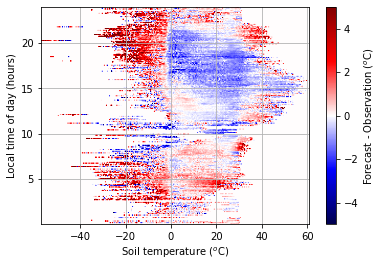

In [6]:
# Make image of the error with the new predictor
buffer, ax_extent, count = imgBufferFromVectors(soil_temperature_test,
                                                time_of_day_test,
                                                forecast_error_test,
                                                256, 256,
                                                extent = [],
                                                calc_average=True)
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Note: It looks like in the evening, around 20:00, the soil freezing might be important.
#       So we introduce another predictor: If the soil is frozen (1) or not (0).

In [7]:
# Fit a cubic polynomial using scikit-learn

# To help the model learn we will create an extra feature to highlight that 0C carries importance.

# Where the soil is frozen (1) or not (0)
soil_frozen_train = soil_temperature_train < 0.0

#Try removing this feature and rerunning the notebook to see if the prediction degrades.

# Create the data using a cubic polynomial.
# (Note that soil_frozen**2 == soil_frozen.)
X = np.concatenate([# Linear terms
              time_of_day_train, soil_temperature_train, soil_frozen_train,
              # Quadratic terms
              time_of_day_train**2,
              time_of_day_train * soil_temperature_train,
              time_of_day_train * soil_frozen_train,
              soil_temperature_train**2,
              soil_temperature_train * soil_frozen_train,
              # Cubic terms
              time_of_day_train**3,
              time_of_day_train**2 * soil_temperature_train,
              time_of_day_train**2 * soil_frozen_train,
              time_of_day_train    * soil_temperature_train**2,
              time_of_day_train    * soil_temperature_train * soil_frozen_train,
              soil_temperature_train**3,
              soil_temperature_train**2 * soil_frozen_train,
              ],axis=-1)

# Create linear regression object
reg = linear_model.LinearRegression()

# Train the model using the train sets
reg.fit(X, forecast_error_train)

# Rename the coefficients found by the fit
c = reg.coef_[0]

In [8]:
# Calculate Root Mean Square error of predictions:

zero_test = 0.0*forecast_error_test
print('Mean Absolute Error Uncorrected:', metrics.mean_absolute_error(zero_test, forecast_error_test))
print('Root Mean Squared Error Uncorrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_error_test)))

#Now apply forecast error correction:
soil_frozen_test = soil_temperature_test < 0.0      # Where the soil is frozen (1) or not (0)
forecast_corrected = forecast_error_test-(reg.intercept_ +
            # Linear terms
            c[0]*time_of_day_test + c[1]*soil_temperature_test + c[2]*soil_frozen_test +
            # Quadratic terms
            c[3]*time_of_day_test**2 +
            c[4]*time_of_day_test*soil_temperature_test +
            c[5]*time_of_day_test*soil_frozen_test +
            c[6]*soil_temperature_test**2 +
            c[7]*soil_temperature_test*soil_frozen_test +
            # Cubic terms
            c[8]*time_of_day_test**3 +
            c[9]*time_of_day_test**2*soil_temperature_test +
            c[10]*time_of_day_test**2*soil_frozen_test +
            c[11]*time_of_day_test*soil_temperature_test**2 +
            c[12]*time_of_day_test*soil_temperature_test*soil_frozen_test +
            c[13]*soil_temperature_test**3 +
            c[14]*soil_temperature_test**2*soil_frozen_test)

##forecast_corrected = linear_model.predict(X_apply)

print('Mean Absolute Error Corrected:', metrics.mean_absolute_error(zero_test, forecast_corrected))
print('Root Mean Squared Error Corrected:', np.sqrt(metrics.mean_squared_error(zero_test, forecast_corrected)))



Mean Absolute Error Uncorrected: 1.6323756023379807
Root Mean Squared Error Uncorrected: 2.2561352539787456
Mean Absolute Error Corrected: 1.5789160602217729
Root Mean Squared Error Corrected: 2.1904684192212858


### We see a reduction of about ~0.06C just from using these two predictors. 

### Let's visualise the space 

In [9]:
# Run the fit model over the plot domain

# The x and y values of each point in the plot image
nx = buffer.shape[0]
ny = buffer.shape[1]
x_st = np.linspace(ax_extent[0],ax_extent[1],nx)  # Represents soil_temperature
y_tod = np.linspace(ax_extent[2],ax_extent[3],ny)  # Represents time_of_day

# Create the plot image and fill it with zeros
model_buffer = np.zeros((nx,ny), dtype=np.float32)

# Fill the buffer with model output
for j in range(ny):
    for i in range(nx):
        
        x = x_st[i]      # Represents soil_temperature
        y = y_tod[j]     # Represents time_of_day
        f = x < 0.0      # Where the soil is frozen (1) or not (0)
        
        model_buffer[j,i] = (reg.intercept_ +
                             # Linear terms
                             c[0]*y + c[1]*x + c[2]*f +
                             # Quadratic terms
                             c[3]*y**2 +
                             c[4]*y*x +
                             c[5]*y*f +
                             c[6]*x**2 +
                             c[7]*x*f +
                             # Cubic terms
                             c[8]*y**3 +
                             c[9]*y**2*x +
                             c[10]*y**2*f +
                             c[11]*y*x**2 +
                             c[12]*y*x*f +
                             c[13]*x**3 +
                             c[14]*x**2*f)

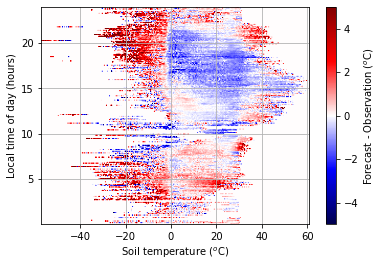

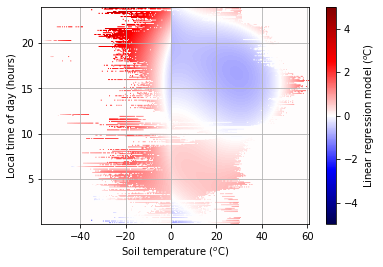

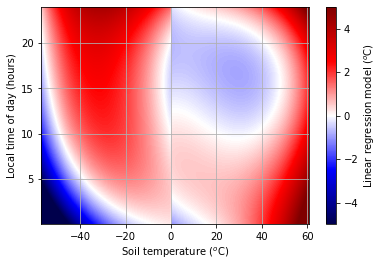

In [10]:
# Plot the image of the error
plt.imshow(buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Forecast - Observation ($^o$C)')

plt.show()

# Plot the model
plt.imshow((model_buffer)*(count>0), vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Linear regression model ($^o$C)')

plt.show()

# Plot the model over the whole domain
plt.imshow(model_buffer, vmin=-5, vmax=5, cmap='seismic', origin='lower',
           extent=ax_extent, aspect='auto')

plt.grid()
plt.xlabel('Soil temperature ($^o$C)')
plt.ylabel("Local time of day (hours)")
cb = plt.colorbar()
cb.set_label('Linear regression model ($^o$C)')

plt.show()

The model constructed with linear regression has a simpler shape than the neural network version (see the other notebook).
However it still produces wild results outside of the training dataset (see cold soil in the early hours of the morning in the bottom plot). 

We have now built a neural network and linear regression model for this problem. Next is random forests.